**Required output_attr_stats.csv, adj_folder, and centrality_folder**

In [1]:
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm,trange
import warnings
import logging
import scipy.sparse
import os
# import altair as alt
# from vega_datasets import data
warnings.filterwarnings("ignore") 
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
def seperate_emails(df_email, by, date_col = 'date_sent'):
    '''
    seperate emails by stage or month
    
    df_email: dataframe with email records 
    by: how to seperate, either by month or by stage
    date_col: name of the date column in df_email
    return: idxes: list of indices, corresponds to each splitting period
    return: idx_labels: list of labels, corresponds to each splitting period
    return: label_colors: dict of label:color, corresponds to each splitting period
    '''
    assert by in ['month', 'stage'], 'not implemented'
    date_email = pd.to_datetime(df_email[date_col])
    colors = ['green', 'blue', 'red', 'orange']
    
    if by == 'stage':
        idxt1 = date_email>datetime(2014,1,23)
        idxt2 = date_email>datetime(2014,5,14)
        idxt3 = date_email>datetime(2016,2,24)
        idxe1 = np.array(idxt1==False)
        idxe2 = np.array((idxt1==True) & (idxt2==False))
        idxe3 = np.array((idxt2==True) & (idxt3==False))
        idxe4 = np.array(idxt3==True)

        idxes = [idxe1, idxe2, idxe3, idxe4]
        idx_labels = ['before 2014,1,23', '2014,1,23 - 2014,5,14', '2014,5,14 - 2016,2,24', 'after 2016,2,24']
        label_colors = {}
        for label, color in zip(idx_labels, colors):
            label_colors[label] = color
    elif by == 'month':
        month = date_email.dt.month
        year = date_email.dt.year
        idxes = []
        idx_labels = []
        
        color = colors[0]
        label_colors = {}
        skip = True # skip initial empty months and ending months
        for y in range(int(year.min()),int(year.max()+1)):
            for m in range(1,13):
                idx = (year == y) * (month == m)
                if idx.sum() == 0 and skip == True:
                    continue
                else:
                    skip = False
                    idxes.append(np.array(idx))
                    label = str(y)+'.'+str(m)
                    idx_labels.append(label)
                    label_colors[label] = color
                    if label == '2014.1':
                        color = colors[1]
                    elif label == '2014.5':
                        color = colors[2]
                    elif label == '2016.2':
                        color = colors[3]
        for i,idx in enumerate(idxes[::-1]): # remove the empty months in the end
            if idx.sum() != 0:
                break
        idxes = idxes[:-i]
        idx_labels = idx_labels[:-i]
    return idxes, idx_labels, label_colors

In [3]:
def cal_graph_stats(adj_folder, idxes, by):
    graph_stats = np.zeros((len(idxes),2))
    for k in trange(len(idxes)):
        infile = adj_folder+'/adjmat_'+by+'_'+str(k)+'.npz'
        if os.path.exists(infile):
            sparse_matrix = scipy.sparse.load_npz(infile)
            email_adj_mat = np.asarray(sparse_matrix.todense())
            G = nx.from_numpy_array(email_adj_mat, create_using=nx.DiGraph)
            graph_stats[k,0] = nx.density(G)  # network density
            graph_stats[k,1] = ((email_adj_mat.sum(axis=0) != 0) * (email_adj_mat.sum(axis=1) != 0)).sum()/G.size() # number of active nodes
        else: # if file not exist, it means there are no email found during that period. Remain 0
            print(f'infile {infile} not found! Indicating no email found during the period.')
            pass
    return graph_stats

In [4]:
def cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name):
    centrality_stats = np.zeros((len(idxes),4))
    for k in trange(len(idxes)):
        infile = centrality_folder+'/'+by+'_'+str(k)+'_alpha_'+str(alpha)+'_'+centrality_name+'.npz'
        if os.path.exists(infile):
            sparse_matrix = scipy.sparse.load_npz(infile)
            centr = np.asarray(sparse_matrix.todense()).reshape(-1)
            centrality_stats[k,0] = centr.min()
            centrality_stats[k,1] = centr.mean()
            centrality_stats[k,2] = centr.max()
            centrality_stats[k,3] = centr.std()
        else:
            print(f'infile {infile} not found! Indicating no email found during the period.')
            pass
    return centrality_stats

In [50]:
def centrality_density_plot(graph_stats, centrality_stats, idxes, idx_labels, label_colors, title, start_idx = 0):
    fig, ax1 = plt.subplots(figsize = (15,4))

    x = centrality_stats[start_idx:,1]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(title, fontsize = 24)
    ax1.bar(np.arange(len(idxes)-start_idx), x, label = 'avg centrality', alpha = 0.6, color = 'black')
    ax1.legend(loc=2)
    # the range is too large
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,10], y2 = centrality[:,8], color = 'red', alpha = 0.3)
    # plt.fill_between(np.arange(len(idxes)) , y1 = centrality[:,9] + centrality[:,11], y2 = centrality[:,9] - centrality[:,11], color = 'red', alpha = 0.3)
    ax1.set_xticks(np.arange(len(idxes)-start_idx))
    ax1.set_xticklabels(idx_labels[start_idx:], rotation = 90, fontsize = 14)
    ax1.set_xlabel('time', fontsize = 16)
    ax1.set_ylabel('avg centrality', color='black', fontsize = 20)
    ax1.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax1.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    #for ticklabel in plt.gca().get_xticklabels():
    #    ticklabel.set_color(label_colors[ticklabel.get_text()])
    ax1.grid(axis = 'y')

#     x = centrality_stats[start_idx:,3]
#     ax2 = ax1.twinx()
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['bottom'].set_visible(False)
    
    
#     ax2.plot(x ,label = 'std centrality', c = 'black', linewidth = 3, ls = 'dashed')
#     ax2.set_ylabel('std centrality', color='black', fontsize = 20, x = 2.4, y = 0.5)
#     ax2.yaxis.set_label_coords(-0.14 ,0.5) 
#     ax2.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax2.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax2.legend(loc=2, bbox_to_anchor=(0.0,0.9))

    x =centrality_stats[start_idx:,3]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(x, label = 'std centrality', c = 'black', linewidth = 3, alpha = 0.6)
    ax3.set_ylabel('std centrality', color='black', fontsize = 20)
    ax3.set_yticks(np.linspace(x.min(), x.max(), 7))
    ax3.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
    ax3.legend(loc=1)


    #x = graph_stats[start_idx:,1]
    
    #ax4 = ax1.twinx()
    #ax4.spines['right'].set_visible(False)
    #ax4.spines['left'].set_visible(False)
    #ax4.spines['top'].set_visible(False)
#     ax4.spines['bottom'].set_visible(False)
#     ax4.spines["right"].set_position(("axes", 1.08))
#     ax4.plot(x, label = 'modified density', c = 'black', linewidth = 2, alpha = 0.6)
#     ax4.set_ylabel('modified density', color='black', fontsize = 20, x = 1.2, y = 0.5)
#     ax4.set_yticks(np.linspace(x.min(), x.max(), 7))
#     ax4.set_ylim(x.min() - 0.01*(x.max()-x.min()), x.max() + 0.01*(x.max()-x.min()))
#     ax4.legend(loc=1, bbox_to_anchor=(1.0,0.9))

    plt.tight_layout()
    #plt.show()
    plt.savefig("degree_centrality.png",dpi=300)
    

### scripts starting from here

In [11]:
df_email = pd.read_csv('output_attr_stats.csv')

In [12]:
by = 'month'
idxes, idx_labels, label_colors = seperate_emails(df_email, by, date_col = 'date_sent')

In [13]:
adj_folder = "./undirected_adj_03212022"
graph_stats = cal_graph_stats(adj_folder, idxes, by)

infile ./undirected_adj_03212022/adjmat_month_1.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_2.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_3.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_4.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_5.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_6.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_7.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_8.npz not found! Indicating no email found during the period.
infile ./undirected_adj_03212022/adjmat_month_9.npz not found! Indicating no email found during the period.
infile ./undirected_adj_0321

In [14]:
centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'closeness'
alpha = 1
closeness_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./centrality_weighted_03212022/month_1_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_closeness.npz not found! Indicating no email found during the period.
infile .

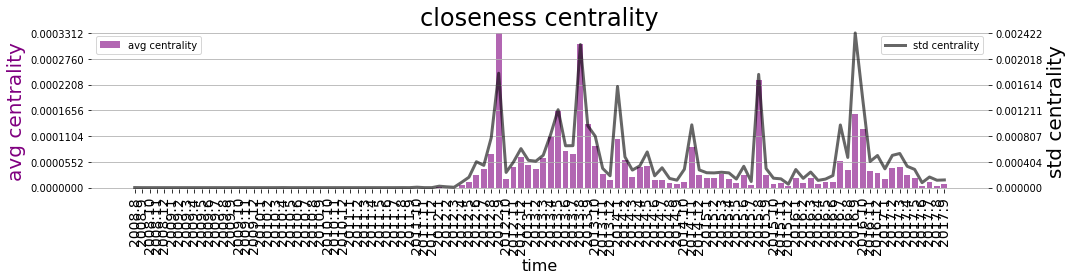

In [33]:
title = 'closeness centrality'
centrality_density_plot(graph_stats, closeness_stats, idxes, idx_labels, label_colors, title)

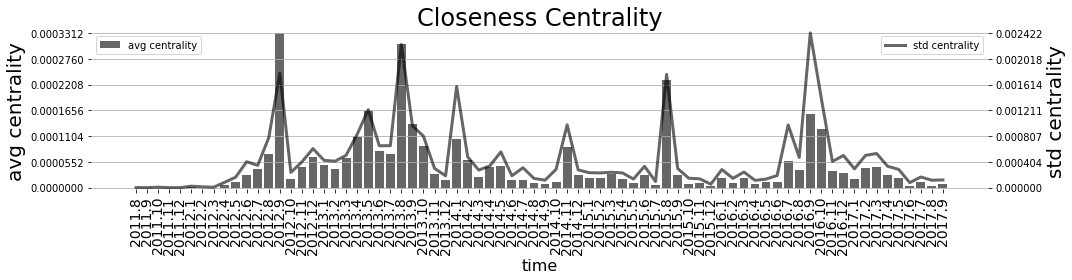

In [44]:
title = 'Closeness Centrality'
centrality_density_plot(graph_stats, closeness_stats, idxes, idx_labels, label_colors, title, start_idx=36)


In [47]:
centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'betweenness'
alpha = 1
betweenness_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./centrality_weighted_03212022/month_1_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_betweenness.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_betweenness.npz not found! Indicating no email found during the 

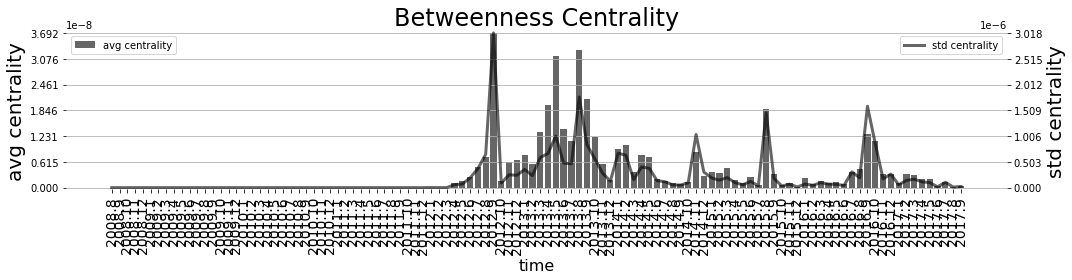

In [48]:
title = 'Betweenness Centrality'
centrality_density_plot(graph_stats, betweenness_stats, idxes, idx_labels, label_colors, title)

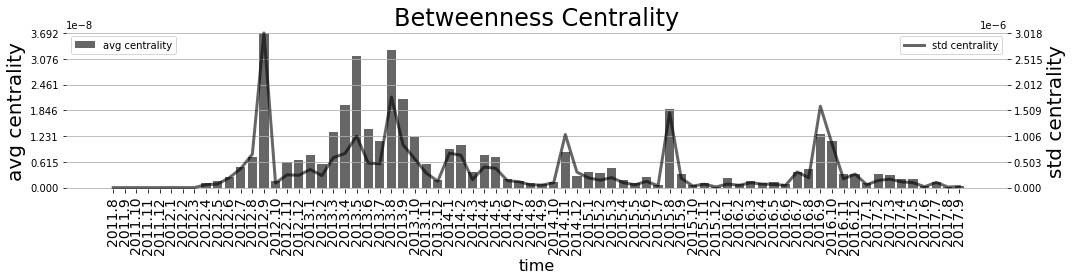

In [49]:
title = 'Betweenness Centrality'
centrality_density_plot(graph_stats, betweenness_stats, idxes, idx_labels, label_colors, title, start_idx=36)

In [51]:
centrality_folder = "./centrality_weighted_03212022"
centrality_name = 'degree'
alpha = 1
degree_stats = cal_centrality_stats(centrality_folder, idxes, by, alpha, centrality_name)

infile ./centrality_weighted_03212022/month_1_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_2_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_3_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_4_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_5_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_6_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_7_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_03212022/month_8_alpha_1_degree.npz not found! Indicating no email found during the period.
infile ./centrality_weighted_032

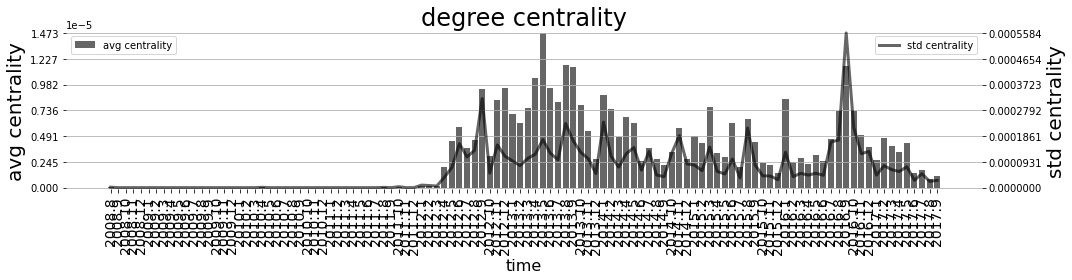

In [52]:
title = 'degree centrality'
centrality_density_plot(graph_stats, degree_stats, idxes, idx_labels, label_colors, title)

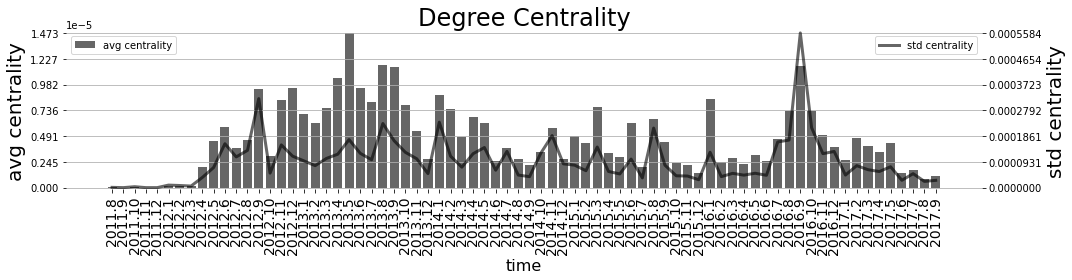

In [53]:
title = 'Degree Centrality'
centrality_density_plot(graph_stats, degree_stats, idxes, idx_labels, label_colors, title, start_idx=36)